# Clustering code examples

In [17]:
# (da kaggle https://www.kaggle.com/code/ranja7/clustering-with-dbscan-compare-with-gmm?scriptVersionId=107998781)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import math

from sklearn import metrics
from sklearn.datasets import make_circles
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

from sklearn.mixture import GaussianMixture

from plt_parameters import get_colors_to_cycle_rainbow8, get_colors_to_cycle_rainbowN, get_colors_to_cycle_sequential

In [2]:
# genero dati di esempio
X, y = make_circles(n_samples = 1000, factor = 0.25, noise = 0.05)

In [3]:
X.shape

(1000, 2)

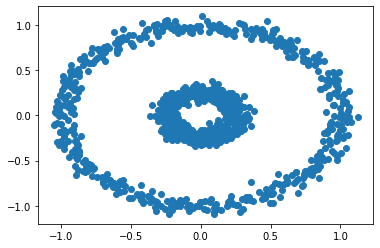

In [4]:
plt.scatter(X[:,0],X[:,1])

In [13]:
X = StandardScaler().fit_transform(X)

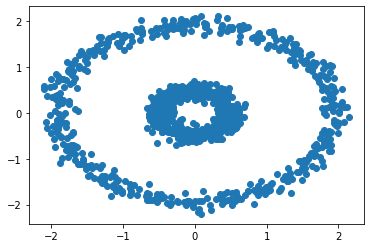

In [14]:
plt.scatter(X[:,0],X[:,1])

Text(0, 0.5, 'eps')

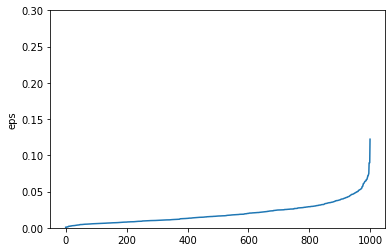

In [5]:
# calcolo del parametro eps
neighbors = NearestNeighbors(n_neighbors = 20)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

distances = np.sort(distances, axis = 0)
distances = distances[:,1]
plt.ylim(0, 0.3)
plt.plot(distances)
plt.ylabel('eps')

#### risulta che 0.3 è il massimo

/tmp/ipykernel_10832/858500968.py:11: RuntimeWarning: invalid value encountered in sqrt
  p = np.sqrt(p) #EUCLIDEAN DISTANCE


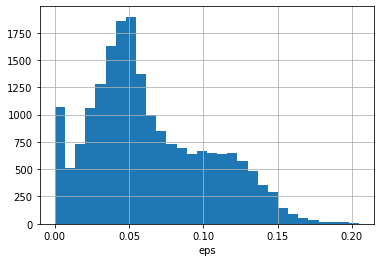

In [6]:
# altro modo per calcolare eps
def k_distances2(x, k):
    """ Function to calculate distance of each point to its k-th NN 
        x: dataset
        k: #NN
    """
    
    dim0 = x.shape[0]
    dim1 = x.shape[1]
    p = -2*x.dot(x.T) + np.sum(x**2, axis = 1).T + np.repeat(np.sum(x**2, axis = 1),dim0, axis = 0).reshape(dim0,dim0)
    p = np.sqrt(p) #EUCLIDEAN DISTANCE
    p.sort(axis = 1)
    p = p[:,:k]
    pm = np.sort(p.flatten())
    
    return p, pm

m, m2 = k_distances2(X, 20)

plt.hist(m2, bins = 30)
plt.xlabel('eps') #epsilon distance
plt.grid(True)

#### anche quì 0.3 è quello che contiene la maggior parte dei punti
(Majority of points lie within 0.3 units from their NNs. Hence, eps = 0.3)

In [7]:
y_pred = DBSCAN(eps = 0.3, min_samples = 20).fit_predict(X)

In [8]:
db = DBSCAN(eps = 0.3, min_samples = 20).fit(X)
labels = db.labels_

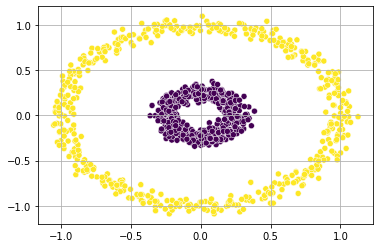

In [9]:
sns.scatterplot(x=X[:,0], y=X[:,1], c = y_pred)
plt.grid()

In [10]:
# cluster diversi trovati - al rumore viene assegnato il valore -1
set(y_pred[np.where(y_pred != -1)])

{0, 1}

### ripeto con le GMM

In [76]:
colors = ["navy", "darkorange"]#, "turquoise"]
def make_ellipses(gmm, ax, colors):
    for n, color in enumerate(colors):
        if gmm.covariance_type == "full":
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == "tied":
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == "diag":
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == "spherical":
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        ell = mpl.patches.Ellipse(
            gmm.means_[n, :2], v[0], v[1], angle=180 + angle, color=color
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect("equal", "datalim")

In [78]:
n_classes = 12
estimators = {
    cov_type: GaussianMixture(
        n_components=n_classes, covariance_type=cov_type, max_iter=20, random_state=0
    )
    for cov_type in ["spherical", "diag", "tied", "full"]
}
estimator = GaussianMixture(n_components=n_classes, covariance_type="full", max_iter=20000, random_state=900)

In [79]:
estimator.fit(X)

GaussianMixture(max_iter=20000, n_components=12, random_state=900)

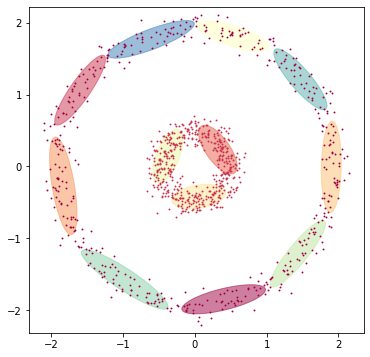

In [80]:
plt.figure(figsize=(6, 6))
h = plt.subplot(1, 1 , 1)
make_ellipses(estimator, h, get_colors_to_cycle_sequential(n_classes))
for i in range(n_classes):
    data = X[y == i]
    labels = y[y == i]
    plt.scatter(data[:, 0], data[:, 1], s=0.8, color = get_colors_to_cycle_sequential(n_classes)[i], label=labels)